In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, precision_recall_curve, auc, f1_score, cohen_kappa_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.feature_selection import RFE, SelectFromModel, RFECV

from IPython import display
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm

from pylab import rcParams

import os
import re
import time
import warnings
warnings.filterwarnings('ignore')

seed = 9001
np.random.seed(seed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Read in processed extracted 6 hour window data training and test set

In [4]:
# training set
X_all = pd.read_csv('6hour_Xtrain.csv')
y_all = pd.read_csv('6hour_ytrain.csv')

# test set
X_test = pd.read_csv('6hour_Xtest.csv')
y_test = pd.read_csv('6hour_ytest.csv')

/content/drive/My Drive/sepsis


In [5]:
print(X_all.shape)
print(X_test.shape)

(1080424, 64)
(270106, 64)


### Define threshold that gives best F1-score

In [0]:
def performance2(y, y_pred, print_ = 1, *args):   
    """ Calculate performance measures for a given ground truth classification y and predicted 
    probabilities y_pred. If *args is provided a pre-defined threshold is used to calculate the performance.
    If not, the threshold giving the best mean sensitivity and specificity is selected. The AUC is calculated
    for a range of thresholds using the metrics package from sklearn. """

    # xx and yy values for ROC curve
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
    # area under the ROC curve
    AUC = auc(fpr, tpr)

    # xx and yy values for AUPR
    precision, recall, thresholds = precision_recall_curve(y, y_pred, pos_label=1)
    # convert to f1-score
    fscore = (2*precision*recall) / (precision+recall)
    fscore[np.isnan(fscore)] = 0

    # if a threshold is specified, use it
    if args:
        threshold = args[0]
    else:
    # if a threshold is not specified, we will choose the threshold that gives the best f1-score
        ix = np.argmax(fscore)
        threshold = thresholds[ix]        
        
    # transform the predicted probability into a binary classification
    y_pred[y_pred >= threshold] = 1
    y_pred[y_pred < threshold] = 0
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        
    # basic accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # for auc
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    
    # for f1-score
    precision1 = tp/(tp+fp)
    recall1 = sensitivity # detection rate
    
    # for false alarm rate
    fpr2 = fp/(fp+tn) # distinguish with false positive rate from calculating AUC
    fnr = fn/(fn+tp)
    
    # f1-score
    f1 = max(fscore)

    # kappa score
    kappa = cohen_kappa_score(y, y_pred)

    
    # print the performance and plot the ROC curve    
    if print_ == 1:
        print('Threshold: ' + str(round(threshold, 2)))
        print('TP: ' + str(tp))
        print('TN: ' + str(tn))
        print('FP: ' + str(fp))
        print('FN: ' + str(fn))
        
        print("Accuracy: " + str(round(accuracy, 2)))
        print('Sensitivity: ' + str(round(sensitivity, 2)))
        print('Specificity: ' + str(round(specificity, 2)))
        print('Precision: ' + str(round(precision1, 2)))
        print('Recall (Detection rate): ' + str(round(recall1, 2)))
        print('F1-score: ' + str(round(f1, 2)))
        print('AUC: ' + str(round(AUC, 2)))
        print('FPR (False alarm rate): ' + str(round(fpr2, 2)))
        print('FNR: ' + str(round(fnr, 2)))
        print('Kappa: ' + str(round(kappa, 2)))
    
        plt.figure(figsize = (4,3))
        plt.scatter(x = fpr, y = tpr, label = None)
        plt.plot(fpr, tpr, label = 'Classifier', zorder = 1)
        plt.plot([0, 1], [0, 1], 'k--', label = 'Random classifier')
        plt.scatter(x = 1 - specificity, y = sensitivity, c = 'black', label = 'Operating point', zorder = 2)
        plt.legend()
        plt.xlabel('1 - specificity')
        plt.ylabel('sensitivity')
        plt.show()
        

    return threshold, accuracy, sensitivity, specificity, AUC, precision1, recall1, f1, fpr2, fnr, kappa

### Create function to evaluate model performance on training and test set maximizing F1-score

In [0]:
def model_evaluation2(model, X_train, y_train, X_test, y_test, print_):
    
    # tune - parameter estimation 
    print('TRAINING SET')
    y_pred_prob_train = model.predict_proba(X_train)
    threshold, accuracy_tr, sensitivity_tr, specificity_tr, AUC_tr, precision_tr, \
    recall_tr, f1_tr, fpr_tr, fnr_tr, kappa_tr = performance2(y_train, np.delete(y_pred_prob_train, 0, 1), print_) # retain the probabilities of positive class only

    # test
    print('TEST SET')
    y_pred_prob_test = model.predict_proba(X_test)
    _, accuracy_test, sensitivity_test, specificity_test, AUC_test, precision_test, \
     recall_test, f1_test, fpr_test, fnr_test, kappa_test = performance2(y_test, np.delete(y_pred_prob_test, 0, 1), print_, threshold)
    
    # save the results
    results_train = pd.DataFrame(data = [[threshold, accuracy_tr, sensitivity_tr, specificity_tr, AUC_tr,
                                          precision_tr, recall_tr, f1_tr, fpr_tr, fnr_tr, kappa_tr, X_train.shape[1]]],
                                 columns = ['Threshold','Accuracy', 'Sensitivity', 'Specificity', 'AUROC',
                                            'Precision', 'Recall', 'F1', 'FPR (False Alarm)', 'FNR', 'Kappa', '# features'])

    results_test = pd.DataFrame(data = [[threshold, accuracy_test, sensitivity_test, specificity_test, AUC_test,
                                          precision_test, recall_test, f1_test, fpr_test, fnr_test, kappa_test, X_train.shape[1]]],
                                columns = ['Threshold','Accuracy', 'Sensitivity', 'Specificity', 'AUROC',
                                           'Precision', 'Recall', 'F1', 'FPR (False Alarm)', 'FNR', 'Kappa', '# features'])
        
    return results_train, results_test, y_pred_prob_train, y_pred_prob_test

### Create a stratified cv (to preserve class distribution during Cross-validation)

In [0]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)

# 50/50 Ratio

### Create balanced data using Random Oversampling

In [0]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=seed)

In [0]:
X_ovs, y_ovs = ros.fit_resample(X_all, y_all)

In [11]:
print('Sepsis patterns after Random Over-sampling:', np.count_nonzero(y_ovs == 1))
print('Non-sepsis patterns after Random Over-sampling:', np.count_nonzero(y_ovs == 0))

Sepsis patterns after Random Over-sampling: 1060315
Non-sepsis patterns after Random Over-sampling: 1060315


### Create balanced data using Random Undersampling

In [0]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=seed)

In [0]:
X_uds, y_uds = rus.fit_resample(X_all, y_all)

In [14]:
print('Sepsis patterns after Random Under-sampling:', np.count_nonzero(y_uds == 1))
print('Non-sepsis patterns after Random Under-sampling:', np.count_nonzero(y_uds == 0))

Sepsis patterns after Random Under-sampling: 20109
Non-sepsis patterns after Random Under-sampling: 20109


# 80/20 Ratio

In [0]:
ratio8020 = RandomUnderSampler(sampling_strategy=1/4, random_state=seed)

In [0]:
X_8020, y_8020 = ratio8020.fit_resample(X_all, y_all)

In [17]:
print('Sepsis patterns for 80/20 ratio:', np.count_nonzero(y_8020 == 1))
print('Non-sepsis patterns for 80/20 ratio:', np.count_nonzero(y_8020 == 0))

Sepsis patterns for 80/20 ratio: 20109
Non-sepsis patterns for 80/20 ratio: 80436


# 90/10 Ratio

In [0]:
ratio9010 = RandomUnderSampler(sampling_strategy=1/9, random_state=seed)

In [0]:
X_9010, y_9010 = ratio9010.fit_resample(X_all, y_all)

In [20]:
print('Sepsis patterns for 90/10 ratio:', np.count_nonzero(y_9010 == 1))
print('Non-sepsis patterns for 90/10 ratio:', np.count_nonzero(y_9010 == 0))

Sepsis patterns for 90/10 ratio: 20109
Non-sepsis patterns for 90/10 ratio: 180981


# 95/5 Ratio

In [0]:
ratio9505 = RandomUnderSampler(sampling_strategy=5/95, random_state=seed)

In [0]:
X_9505, y_9505 = ratio9505.fit_resample(X_all, y_all)

In [23]:
print('Sepsis patterns for 95/05 ratio:', np.count_nonzero(y_9505 == 1))
print('Non-sepsis patterns for 95/05 ratio:', np.count_nonzero(y_9505 == 0))

Sepsis patterns for 95/05 ratio: 20109
Non-sepsis patterns for 95/05 ratio: 382071


# 98/02: original dataset

In [24]:
print('Sepsis patterns for original ratio:', np.count_nonzero(y_all == 1))
print('Non-sepsis patterns for original ratio:', np.count_nonzero(y_all == 0))

Sepsis patterns for original ratio: 20109
Non-sepsis patterns for original ratio: 1060315


# 1. Logistic Regression

## 50/50 Ratio

### Random Over-sampling with all variables

In [0]:
lr_ovs = LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)

In [26]:
start = datetime.now()

lr_ovs.fit(X_ovs, y_ovs)

print('Training took: ', datetime.now()-start)

Training took:  0:00:22.624947


### Performance on training and test sets

TRAINING SET
Threshold: 0.36
TP: 934692
TN: 300624
FP: 759691
FN: 125623
Accuracy: 0.58
Sensitivity: 0.88
Specificity: 0.28
Precision: 0.55
Recall (Detection rate): 0.88
F1-score: 0.68
AUC: 0.68
FPR (False alarm rate): 0.72
FNR: 0.12
Kappa: 0.17


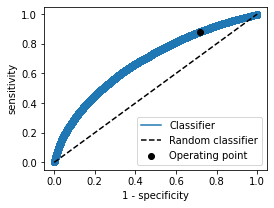

TEST SET
Threshold: 0.36
TP: 4382
TN: 74714
FP: 190365
FN: 645
Accuracy: 0.29
Sensitivity: 0.87
Specificity: 0.28
Precision: 0.02
Recall (Detection rate): 0.87
F1-score: 0.09
AUC: 0.67
FPR (False alarm rate): 0.72
FNR: 0.13
Kappa: 0.01


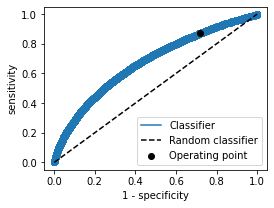

In [27]:
results_train_lr_ovs_all, results_test_lr_ovs_all, \
y_pred_prob_train_lr_ovs, y_pred_prob_test_lr_ovs = model_evaluation2(lr_ovs, 
                                                                      X_ovs, y_ovs,
                                                                      X_test, y_test,
                                                                      print_ = 1)

### Save results to dataframe

In [0]:
lr_results_train = pd.DataFrame()
lr_results_test = pd.DataFrame()

In [0]:
lr_results_train = lr_results_train.append(results_train_lr_ovs_all.rename(index={results_train_lr_ovs_all.index[-1]: 'LR Over-sampling All features'}))
lr_results_test = lr_results_test.append(results_test_lr_ovs_all.rename(index={results_test_lr_ovs_all.index[-1]: 'LR Over-sampling All features'}))

### Random Under-sampling with all variables

In [0]:
lr_uds = LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)

In [31]:
start = datetime.now()

lr_uds.fit(X_uds, y_uds)

print('Training took: ', datetime.now()-start)

Training took:  0:00:00.663937


### Performance on training and test set

TRAINING SET
Threshold: 0.35
TP: 17891
TN: 5365
FP: 14744
FN: 2218
Accuracy: 0.58
Sensitivity: 0.89
Specificity: 0.27
Precision: 0.55
Recall (Detection rate): 0.89
F1-score: 0.68
AUC: 0.68
FPR (False alarm rate): 0.73
FNR: 0.11
Kappa: 0.16


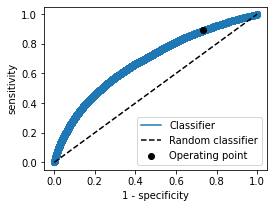

TEST SET
Threshold: 0.35
TP: 4435
TN: 70008
FP: 195071
FN: 592
Accuracy: 0.28
Sensitivity: 0.88
Specificity: 0.26
Precision: 0.02
Recall (Detection rate): 0.88
F1-score: 0.1
AUC: 0.67
FPR (False alarm rate): 0.74
FNR: 0.12
Kappa: 0.01


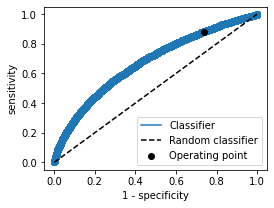

In [32]:
results_train_lr_uds_all, results_test_lr_uds_all, \
y_pred_prob_train_lr_uds, y_pred_prob_test_lr_uds = model_evaluation2(lr_uds, 
                                                                      X_uds, y_uds,
                                                                      X_test, y_test,
                                                                      print_ = 1)

### Save results to dataframe

In [0]:
lr_results_train = lr_results_train.append(results_train_lr_uds_all.rename(index={results_train_lr_uds_all.index[-1]: 'LR Under-sampling All features'}))
lr_results_test = lr_results_test.append(results_test_lr_uds_all.rename(index={results_test_lr_uds_all.index[-1]: 'LR Under-sampling All features'}))

### Random Under-sampling with Recursive Feature Elimination (RFE) for feature selection

In [0]:
lr_uds = LogisticRegression(solver='lbfgs', max_iter=1000)

In [0]:
lr_uds_cv = RFECV(estimator=lr_uds, step=1, cv=kfold, scoring='f1', n_jobs=-1)

In [36]:
start = datetime.now()

lr_uds_cv.fit(X_uds, y_uds)

print('Training took: ', datetime.now()-start)

Training took:  0:00:35.781825


### Optimal Number of features

In [37]:
print('Optimal number of features: {}'.format(lr_uds_cv.n_features_))

Optimal number of features: 53


### Plot the optimal number of features against F1-score

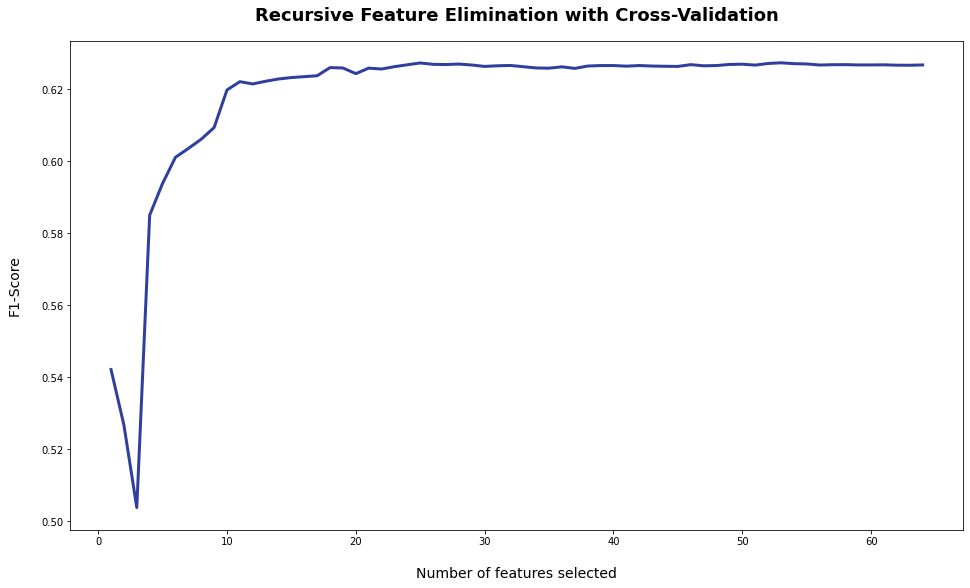

In [38]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('F1-Score', fontsize=14, labelpad=20)
plt.plot(range(1, len(lr_uds_cv.grid_scores_) + 1), lr_uds_cv.grid_scores_, color='#303F9F', linewidth=3)

### Now only select the important features according to the model

In [0]:
rfe_feat = lr_uds_cv.support_

### Use these selected features for Random Undersample dataset

In [0]:
X_uds_rfe, y_uds_rfe = rus.fit_resample(X_all.loc[:, rfe_feat], y_all)

In [41]:
X_all.loc[:, rfe_feat]

,Temp_diff3,Resp_std,O2Sat_std,DBP_std,SBP_std,HR_diff1,O2Sat_diff1,Temp_diff2,HR_diff5,Temp_diff4,Resp_diff5,HR_diff4,HR_diff2,HR_diff3,Resp_min,O2Sat_diff2,O2Sat_diff3,Resp_diff4,O2Sat_mean,Resp_mean,Temp_diff1,Temp_diff5,MAP_min,DBP_diff1,SBP_diff1,O2Sat_min,SBP_min,DBP_diff2,DBP_min,DBP_diff3,SBP_diff2,SBP_diff4,SBP_diff3,MAP_max,MAP_diff1,DBP_max,HR_max,HR_min,Temp_max,Temp_min,MAP_diff2,SBP_mean,MAP_diff4,MAP_diff3,MAP_mean,SBP_max,Temp_std,DBP_mean,HR_mean,HR_std,O2Sat_max,MAP_std,Gender
0,-0.020258,0.582431,1.165242,-1.565140,-0.100423,-0.533278,-1.621677,-0.013301,1.469942,0.366599,1.520423,-1.758811,0.810944,-0.262749,-0.136026,0.011205,1.669399,-1.042822,-0.257952,0.225659,-0.005838,-0.019537,2.060733,-0.004030,1.184451,-0.586981,2.428939,-0.002085,-0.218355,-0.000907,-0.698007,1.039101,-1.033550,1.984130,2.248154,-1.108712,-0.249107,-0.398594,-0.228386,0.234737,0.352274,2.350904,0.802503,-2.109323,2.167066,2.025546,-0.887749,-0.735066,-0.494214,0.316975,0.997467,0.998335,0
1,-0.020258,-0.161286,0.590939,-1.565140,-0.426810,-0.397834,0.009239,-0.013301,0.376658,-0.022875,-0.767137,-0.941465,0.006867,-0.262749,-0.136026,0.011205,0.010632,0.251263,-0.962098,-0.403008,0.388014,-0.019537,0.243862,-0.004030,-0.220884,-1.109181,-1.009552,-0.002085,-0.218355,-0.000907,0.336162,0.408378,0.477899,-0.342644,-0.361590,-1.108712,-0.190966,-0.136763,-0.460255,-0.000762,0.352274,-1.177675,-0.088976,0.263557,-0.087944,-1.233596,-1.014934,-0.735066,-0.193393,0.018641,-1.489824,-1.053614,1
2,-0.020258,0.093771,-0.758338,-1.565140,0.375703,0.141159,-0.398517,-0.013301,0.008629,-0.022875,-1.530315,-0.669550,-0.263786,0.544869,-1.385239,0.422168,0.010632,0.898220,1.098539,-1.616478,0.388014,-0.019537,-0.022197,-0.004030,0.055685,1.306311,0.618126,-0.002085,-0.174296,-0.000907,-0.082382,-0.756775,-0.830229,-0.187452,0.023172,-1.064903,-0.608517,-0.136763,0.173521,0.656408,0.143171,0.500142,-0.795139,-0.533440,-0.167874,0.444149,-1.014934,-0.688061,-0.331641,-1.002432,0.997467,0.105426,0
3,0.889165,-1.168168,0.084334,-0.215155,0.019747,0.007078,0.009239,-0.378487,0.131755,-0.022875,-0.512788,0.007858,0.208647,0.142777,0.807383,1.244196,-0.811120,-0.007534,0.928442,0.302074,-0.005838,0.829998,-1.084504,-0.004030,-0.013935,0.431984,0.404318,0.056790,-2.370934,-0.352598,-1.139790,-0.008627,0.267431,-1.527181,-0.006292,-2.325307,-1.152291,-0.601098,0.711251,0.641137,-0.095141,0.305578,-0.000330,-0.357478,-1.591198,0.241785,0.112553,-2.717441,-0.887285,-1.305481,0.997467,-0.609538,0
4,1.434558,-0.472420,0.687907,2.710147,-0.854744,0.408327,0.824842,-0.013301,-0.739896,-0.022875,-0.004206,0.142421,-0.263786,-0.127116,1.037155,-1.221413,0.838336,0.251263,-1.500226,0.677635,-0.005838,-0.019537,-2.525024,5.089426,-0.358077,-1.331393,-0.606705,1.534149,-3.913921,-0.819936,0.336162,0.758332,-0.830229,-0.080115,2.791573,0.979952,-0.426486,-0.136763,-0.141851,-0.102561,0.802459,-1.068332,-0.442472,-0.621314,-1.574415,-1.181838,0.379275,-1.110037,-0.342376,-0.632079,-1.489824,1.965759,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080419,0.379961,0.276048,0.008552,-0.348464,-0.182119,0.408327,0.009239,-0.013301,-0.364382,-0.022875,-0.258471,-0.262503,-0.263786,0.008121,-0.874366,0.422168,-0.811120,0.768832,-0.007601,-0.813487,-0.005838,-0.019537,-4.625750,0.231317,-0.494924,0.056844,-1.696299,0.233638,-1.744665,-0.469548,0.336162,0.199238,-1.236579,-2.561394,-2.433176,-1.880021,-0.076105,0.301120,-0.141851,0.324066,0.083185,-1.945192,-0.000330,-0.533440,-2.721147,-1.719874,-0.852017,-1.911329,0.096527,-0.780957,-0.007814,1.182749,1
1080420,-0.020258,-0.887500,-1.956384,1.045687,0.937756,0.007078,0.009239,-1.475618,0.008629,-0.022875,-0.004206,0.007858,0.141484,0.008121,0.575333,0.011205,0.010632,-0.007534,-0.702752,0.032604,-0.005838,-0.019537,-0.998816,-0.004030,-0.013935,0.056844,

In [0]:
rfe_features = X_all.loc[:, rfe_feat].columns

In [43]:
rfe_features

Index(['Temp_diff3', 'Resp_std', 'O2Sat_std', 'DBP_std', 'SBP_std', 'HR_diff1',
       'O2Sat_diff1', 'Temp_diff2', 'HR_diff5', 'Temp_diff4', 'Resp_diff5',
       'HR_diff4', 'HR_diff2', 'HR_diff3', 'Resp_min', 'O2Sat_diff2',
       'O2Sat_diff3', 'Resp_diff4', 'O2Sat_mean', 'Resp_mean', 'Temp_diff1',
       'Temp_diff5', 'MAP_min', 'DBP_diff1', 'SBP_diff1', 'O2Sat_min',
       'SBP_min', 'DBP_diff2', 'DBP_min', 'DBP_diff3', 'SBP_diff2',
       'SBP_diff4', 'SBP_diff3', 'MAP_max', 'MAP_diff1', 'DBP_max', 'HR_max',
       'HR_min', 'Temp_max', 'Temp_min', 'MAP_diff2', 'SBP_mean', 'MAP_diff4',
       'MAP_diff3', 'MAP_mean', 'SBP_max', 'Temp_std', 'DBP_mean', 'HR_mean',
       'HR_std', 'O2Sat_max', 'MAP_std', 'Gender'],
      dtype='object')

### Model

In [0]:
lr_uds_rfe = LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)

In [45]:
start = datetime.now()

lr_uds_rfe.fit(X_uds_rfe, y_uds_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:00:00.590398


### Model Performance

TRAINING SET
Threshold: 0.35
TP: 17927
TN: 5298
FP: 14811
FN: 2182
Accuracy: 0.58
Sensitivity: 0.89
Specificity: 0.26
Precision: 0.55
Recall (Detection rate): 0.89
F1-score: 0.68
AUC: 0.68
FPR (False alarm rate): 0.74
FNR: 0.11
Kappa: 0.15


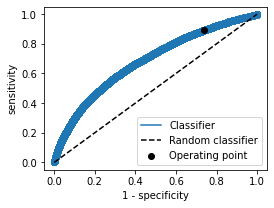

TEST SET
Threshold: 0.35
TP: 4440
TN: 69075
FP: 196004
FN: 587
Accuracy: 0.27
Sensitivity: 0.88
Specificity: 0.26
Precision: 0.02
Recall (Detection rate): 0.88
F1-score: 0.09
AUC: 0.67
FPR (False alarm rate): 0.74
FNR: 0.12
Kappa: 0.01


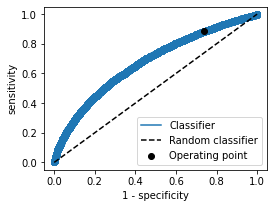

In [46]:
results_train_lr_uds_rfe, results_test_lr_uds_rfe, \
y_pred_prob_train_lr_rfe, y_pred_prob_test_lr_rfe = model_evaluation2(lr_uds_rfe, 
                                                                      X_uds_rfe, y_uds_rfe,
                                                                      X_test.loc[:, rfe_feat], y_test,
                                                                      print_ = 1)

### Save results to dataframe

In [0]:
lr_results_train = lr_results_train.append(results_train_lr_uds_rfe.rename(index={results_train_lr_uds_rfe.index[-1]: 'LR Under-sampling with Feature Selection'}))
lr_results_test = lr_results_test.append(results_test_lr_uds_rfe.rename(index={results_test_lr_uds_rfe.index[-1]: 'LR Under-sampling with Feature Selection'}))

# 80/20 Ratio: All features

In [0]:
# lr_8020 = LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000, class_weight='balanced')
lr_8020 = LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)

In [49]:
start = datetime.now()

lr_8020.fit(X_8020, y_8020)

print('Training took: ', datetime.now()-start)

Training took:  0:00:01.265083


### Performance on training and test set

TRAINING SET
Threshold: 0.21
TP: 11989
TN: 54674
FP: 25762
FN: 8120
Accuracy: 0.66
Sensitivity: 0.6
Specificity: 0.68
Precision: 0.32
Recall (Detection rate): 0.6
F1-score: 0.41
AUC: 0.68
FPR (False alarm rate): 0.32
FNR: 0.4
Kappa: 0.21


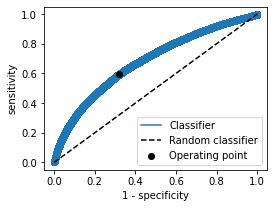

TEST SET
Threshold: 0.21
TP: 2934
TN: 179441
FP: 85638
FN: 2093
Accuracy: 0.68
Sensitivity: 0.58
Specificity: 0.68
Precision: 0.03
Recall (Detection rate): 0.58
F1-score: 0.1
AUC: 0.67
FPR (False alarm rate): 0.32
FNR: 0.42
Kappa: 0.03


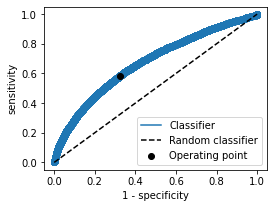

In [50]:
results_train_lr_8020, results_test_lr_8020, \
y_pred_prob_train_lr_8020, y_pred_prob_test_lr_8020 = model_evaluation2(lr_8020, 
                                                                        X_8020, y_8020,
                                                                        X_test, y_test,
                                                                        print_ = 1)

### Save results to dataframe

In [0]:
lr_results_train = lr_results_train.append(results_train_lr_8020.rename(index={results_train_lr_8020.index[-1]: 'LR 80/20 Ratio All features'}))
lr_results_test = lr_results_test.append(results_test_lr_8020.rename(index={results_test_lr_8020.index[-1]: 'LR 80/20 Ratio All features'}))

# 80/20 Ratio: Feature selection

### Use the selected features for 80/20 dataset

In [0]:
X_8020_rfe, y_8020_rfe = ratio8020.fit_resample(X_all.loc[:, rfe_feat], y_all)

### Model

In [0]:
lr_8020_rfe = LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)

In [54]:
start = datetime.now()

lr_8020_rfe.fit(X_8020_rfe, y_8020_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:00:01.278482


### Model Performance

TRAINING SET
Threshold: 0.21
TP: 12042
TN: 54431
FP: 26005
FN: 8067
Accuracy: 0.66
Sensitivity: 0.6
Specificity: 0.68
Precision: 0.32
Recall (Detection rate): 0.6
F1-score: 0.41
AUC: 0.68
FPR (False alarm rate): 0.32
FNR: 0.4
Kappa: 0.21


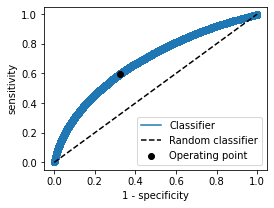

TEST SET
Threshold: 0.21
TP: 2942
TN: 178675
FP: 86404
FN: 2085
Accuracy: 0.67
Sensitivity: 0.59
Specificity: 0.67
Precision: 0.03
Recall (Detection rate): 0.59
F1-score: 0.1
AUC: 0.67
FPR (False alarm rate): 0.33
FNR: 0.41
Kappa: 0.03


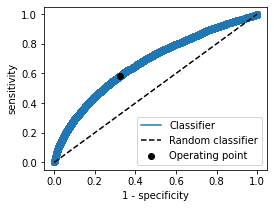

In [55]:
results_train_lr_8020_rfe, results_test_lr_8020_rfe, \
y_pred_prob_train_lr_8020_rfe, y_pred_prob_test_lr_8020_rfe = model_evaluation2(lr_8020_rfe, 
                                                                                X_8020_rfe, y_8020_rfe,
                                                                                X_test.loc[:, rfe_feat], y_test,
                                                                                print_ = 1)

### Save results to dataframe

In [0]:
lr_results_train = lr_results_train.append(results_train_lr_8020_rfe.rename(index={results_train_lr_8020_rfe.index[-1]: 'LR 80/20 Ratio with Feature Selection'}))
lr_results_test = lr_results_test.append(results_test_lr_8020_rfe.rename(index={results_test_lr_8020_rfe.index[-1]: 'LR 80/20 Ratio with Feature Selection'}))

# 90/10 Ratio: All features

In [0]:
lr_9010 = LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)

In [58]:
start = datetime.now()

lr_9010.fit(X_9010, y_9010)

print('Training took: ', datetime.now()-start)

Training took:  0:00:02.689226


### Performance on training and test set

TRAINING SET
Threshold: 0.15
TP: 7664
TN: 154161
FP: 26820
FN: 12445
Accuracy: 0.8
Sensitivity: 0.38
Specificity: 0.85
Precision: 0.22
Recall (Detection rate): 0.38
F1-score: 0.28
AUC: 0.68
FPR (False alarm rate): 0.15
FNR: 0.62
Kappa: 0.18


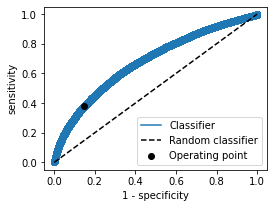

TEST SET
Threshold: 0.15
TP: 1867
TN: 225823
FP: 39256
FN: 3160
Accuracy: 0.84
Sensitivity: 0.37
Specificity: 0.85
Precision: 0.05
Recall (Detection rate): 0.37
F1-score: 0.1
AUC: 0.67
FPR (False alarm rate): 0.15
FNR: 0.63
Kappa: 0.05


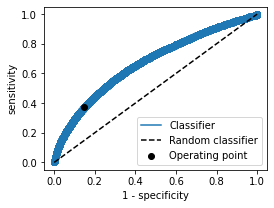

In [59]:
results_train_lr_9010, results_test_lr_9010, \
y_pred_prob_train_lr_9010, y_pred_prob_test_lr_9010 = model_evaluation2(lr_9010, 
                                                                        X_9010, y_9010,
                                                                        X_test, y_test,
                                                                        print_ = 1)

### Save results to dataframe

In [0]:
lr_results_train = lr_results_train.append(results_train_lr_9010.rename(index={results_train_lr_9010.index[-1]: 'LR 90/10 Ratio All features'}))
lr_results_test = lr_results_test.append(results_test_lr_9010.rename(index={results_test_lr_9010.index[-1]: 'LR 90/10 Ratio All features'}))

# 90/10 Ratio: Feature selection

### Use the selected features for 90/10 dataset

In [0]:
X_9010_rfe, y_9010_rfe = ratio9010.fit_resample(X_all.loc[:, rfe_feat], y_all)

### Model

In [0]:
lr_9010_rfe = LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)

In [63]:
start = datetime.now()

lr_9010_rfe.fit(X_9010_rfe, y_9010_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:00:02.575641


### Model Performance

TRAINING SET
Threshold: 0.15
TP: 7683
TN: 154026
FP: 26955
FN: 12426
Accuracy: 0.8
Sensitivity: 0.38
Specificity: 0.85
Precision: 0.22
Recall (Detection rate): 0.38
F1-score: 0.28
AUC: 0.68
FPR (False alarm rate): 0.15
FNR: 0.62
Kappa: 0.18


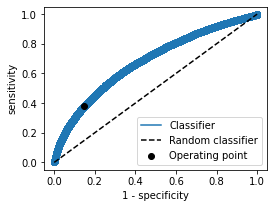

TEST SET
Threshold: 0.15
TP: 1869
TN: 225659
FP: 39420
FN: 3158
Accuracy: 0.84
Sensitivity: 0.37
Specificity: 0.85
Precision: 0.05
Recall (Detection rate): 0.37
F1-score: 0.1
AUC: 0.67
FPR (False alarm rate): 0.15
FNR: 0.63
Kappa: 0.05


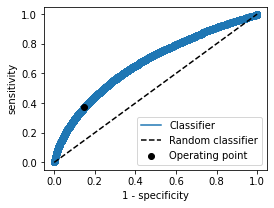

In [64]:
results_train_lr_9010_rfe, results_test_lr_9010_rfe, \
y_pred_prob_train_lr_9010_rfe, y_pred_prob_test_lr_9010_rfe = model_evaluation2(lr_9010_rfe, 
                                                                                X_9010_rfe, y_9010_rfe,
                                                                                X_test.loc[:, rfe_feat], y_test,
                                                                                print_ = 1)

### Save results to dataframe

In [0]:
lr_results_train = lr_results_train.append(results_train_lr_9010_rfe.rename(index={results_train_lr_9010_rfe.index[-1]: 'LR 90/10 Ratio with Feature Selection'}))
lr_results_test = lr_results_test.append(results_test_lr_9010_rfe.rename(index={results_test_lr_9010_rfe.index[-1]: 'LR 90/10 Ratio with Feature Selection'}))

# 95/5 Ratio: All features

In [0]:
lr_9505 = LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)

In [67]:
start = datetime.now()

lr_9505.fit(X_9505, y_9505)

print('Training took: ', datetime.now()-start)

Training took:  0:00:04.710842


### Performance on training and test set

TRAINING SET
Threshold: 0.09
TP: 5472
TN: 349470
FP: 32601
FN: 14637
Accuracy: 0.88
Sensitivity: 0.27
Specificity: 0.91
Precision: 0.14
Recall (Detection rate): 0.27
F1-score: 0.19
AUC: 0.68
FPR (False alarm rate): 0.09
FNR: 0.73
Kappa: 0.13


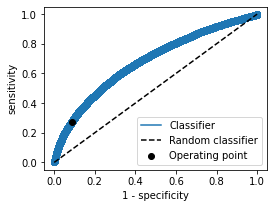

TEST SET
Threshold: 0.09
TP: 1324
TN: 242292
FP: 22787
FN: 3703
Accuracy: 0.9
Sensitivity: 0.26
Specificity: 0.91
Precision: 0.05
Recall (Detection rate): 0.26
F1-score: 0.1
AUC: 0.67
FPR (False alarm rate): 0.09
FNR: 0.74
Kappa: 0.06


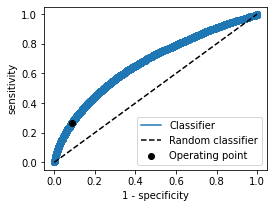

In [68]:
results_train_lr_9505, results_test_lr_9505, \
y_pred_prob_train_lr_9505, y_pred_prob_test_lr_9505 = model_evaluation2(lr_9505, 
                                                                        X_9505, y_9505,
                                                                        X_test, y_test,
                                                                        print_ = 1)

### Save results to dataframe

In [0]:
lr_results_train = lr_results_train.append(results_train_lr_9505.rename(index={results_train_lr_9505.index[-1]: 'LR 95/05 Ratio All features'}))
lr_results_test = lr_results_test.append(results_test_lr_9505.rename(index={results_test_lr_9505.index[-1]: 'LR 95/05 Ratio All features'}))

# 95/05 Ratio: Feature selection

### Use the selected features for 95/05 dataset

In [0]:
X_9505_rfe, y_9505_rfe = ratio9505.fit_resample(X_all.loc[:, rfe_feat], y_all)

### Model

In [0]:
lr_9505_rfe = LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)

In [72]:
start = datetime.now()

lr_9505_rfe.fit(X_9505_rfe, y_9505_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:00:04.695993


### Model Performance

TRAINING SET
Threshold: 0.09
TP: 6008
TN: 344297
FP: 37774
FN: 14101
Accuracy: 0.87
Sensitivity: 0.3
Specificity: 0.9
Precision: 0.14
Recall (Detection rate): 0.3
F1-score: 0.19
AUC: 0.68
FPR (False alarm rate): 0.1
FNR: 0.7
Kappa: 0.13


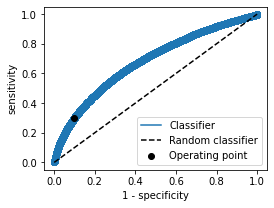

TEST SET
Threshold: 0.09
TP: 1467
TN: 238687
FP: 26392
FN: 3560
Accuracy: 0.89
Sensitivity: 0.29
Specificity: 0.9
Precision: 0.05
Recall (Detection rate): 0.29
F1-score: 0.1
AUC: 0.67
FPR (False alarm rate): 0.1
FNR: 0.71
Kappa: 0.06


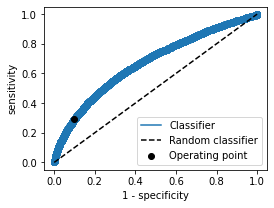

In [73]:
results_train_lr_9505_rfe, results_test_lr_9505_rfe, \
y_pred_prob_train_lr_9505_rfe, y_pred_prob_test_lr_9505_rfe = model_evaluation2(lr_9505_rfe, 
                                                                                X_9505_rfe, y_9505_rfe,
                                                                                X_test.loc[:, rfe_feat], y_test,
                                                                                print_ = 1)

### Save results to dataframe

In [0]:
lr_results_train = lr_results_train.append(results_train_lr_9505_rfe.rename(index={results_train_lr_9505_rfe.index[-1]: 'LR 95/05 Ratio with Feature Selection'}))
lr_results_test = lr_results_test.append(results_test_lr_9505_rfe.rename(index={results_test_lr_9505_rfe.index[-1]: 'LR 95/05 Ratio with Feature Selection'}))

# 98/2 Ratio: All features

In [0]:
lr_9802 = LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)

In [76]:
start = datetime.now()

lr_9802.fit(X_all, y_all)

print('Training took: ', datetime.now()-start)

Training took:  0:00:12.141807


### Performance on training and test set

TRAINING SET
Threshold: 0.05
TP: 3431
TN: 1016595
FP: 43720
FN: 16678
Accuracy: 0.94
Sensitivity: 0.17
Specificity: 0.96
Precision: 0.07
Recall (Detection rate): 0.17
F1-score: 0.1
AUC: 0.68
FPR (False alarm rate): 0.04
FNR: 0.83
Kappa: 0.08


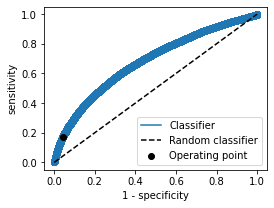

TEST SET
Threshold: 0.05
TP: 818
TN: 254075
FP: 11004
FN: 4209
Accuracy: 0.94
Sensitivity: 0.16
Specificity: 0.96
Precision: 0.07
Recall (Detection rate): 0.16
F1-score: 0.1
AUC: 0.67
FPR (False alarm rate): 0.04
FNR: 0.84
Kappa: 0.07


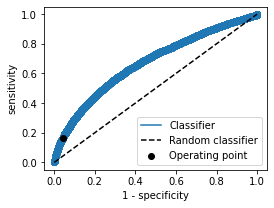

In [77]:
results_train_lr_9802, results_test_lr_9802, \
y_pred_prob_train_lr_9802, y_pred_prob_test_lr_9802 = model_evaluation2(lr_9802, 
                                                                        X_all, y_all,
                                                                        X_test, y_test,
                                                                        print_ = 1)

### Save results to dataframe

In [0]:
lr_results_train = lr_results_train.append(results_train_lr_9802.rename(index={results_train_lr_9802.index[-1]: 'LR 98/02 Ratio All features'}))
lr_results_test = lr_results_test.append(results_test_lr_9802.rename(index={results_test_lr_9802.index[-1]: 'LR 98/02 Ratio All features'}))

# 98/02 Ratio: Feature selection

### Use the selected features for 98/02 dataset

In [0]:
X_9802_rfe, y_9802_rfe = X_all.loc[:, rfe_feat], y_all

### Model

In [0]:
lr_9802_rfe = LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)

In [81]:
start = datetime.now()

lr_9802_rfe.fit(X_9802_rfe, y_9802_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:00:11.332830


### Model Performance

TRAINING SET
Threshold: 0.04
TP: 3582
TN: 1013283
FP: 47032
FN: 16527
Accuracy: 0.94
Sensitivity: 0.18
Specificity: 0.96
Precision: 0.07
Recall (Detection rate): 0.18
F1-score: 0.1
AUC: 0.68
FPR (False alarm rate): 0.04
FNR: 0.82
Kappa: 0.08


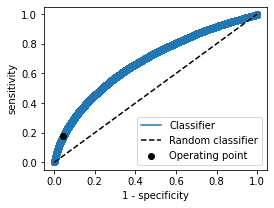

TEST SET
Threshold: 0.04
TP: 862
TN: 253183
FP: 11896
FN: 4165
Accuracy: 0.94
Sensitivity: 0.17
Specificity: 0.96
Precision: 0.07
Recall (Detection rate): 0.17
F1-score: 0.1
AUC: 0.67
FPR (False alarm rate): 0.04
FNR: 0.83
Kappa: 0.07


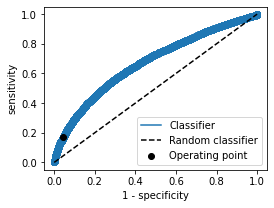

In [82]:
results_train_lr_9802_rfe, results_test_lr_9802_rfe, \
y_pred_prob_train_lr_9802_rfe, y_pred_prob_test_lr_9802_rfe = model_evaluation2(lr_9802_rfe, 
                                                                                X_9802_rfe, y_9802_rfe,
                                                                                X_test.loc[:, rfe_feat], y_test,
                                                                                print_ = 1)

### Save results to dataframe

In [0]:
lr_results_train = lr_results_train.append(results_train_lr_9802_rfe.rename(index={results_train_lr_9802_rfe.index[-1]: 'LR 98/02 Ratio with Feature Selection'}))
lr_results_test = lr_results_test.append(results_test_lr_9802_rfe.rename(index={results_test_lr_9802_rfe.index[-1]: 'LR 98/02 Ratio with Feature Selection'}))

### Write the Results dataframe to CSV files

In [0]:
lr_results_train.to_csv('LogisticRegression_Train_Results.csv', index=True)
lr_results_test.to_csv('LogisticRegression_Test_Results.csv', index=True)

### Select the 2 best models from training with all features and with feature selection for comparison 

In [85]:
print('Best model with all features: ', lr_results_test.sort_values(by='F1', axis=0, ascending=False).loc[lr_results_test['# features']==64].index[0])
print('Best model with feature selection: ', lr_results_test.sort_values(by='F1', axis=0, ascending=False).loc[lr_results_test['# features']==53].index[0])


Best model with all features:  LR 98/02 Ratio All features
Best model with feature selection:  LR 98/02 Ratio with Feature Selection


### Let's compare these 2 features using AIC and BIC

In [0]:
import statsmodels.api as sm

### AIC & BIC of logistic regression trained on all variables

In [0]:
logit_all_vars = sm.Logit(y_all, X_all)
result_all = logit_all_vars.fit()
result_all.summary2()

### AIC & BIC of logistic regression trained on selected features

In [89]:
logit_selected_vars = sm.Logit(y_9802_rfe, X_9802_rfe)
result_selected = logit_selected_vars.fit()
result_selected.summary2()

Optimization terminated successfully.
         Current function value: 0.356127
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: -2.846     
Dependent Variable: SepsisLabel      AIC:              769643.1241
Date:               2020-05-02 02:15 BIC:              770273.4459
No. Observations:   1080424          Log-Likelihood:   -3.8477e+05
Df Model:           52               LL-Null:          -1.0003e+05
Df Residuals:       1080371          LLR p-value:      1.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Temp_diff3    0.0116    0.0028     4.1281  0.0000   0.0061   0.0171
Resp_std     -0.0275    0.0054    -5.0972  0.0000  -0.0381  -0.0169
O2Sat_std     0.0268    0.0092     2.9078  0.0036   0.0087   0.0449
DBP_std       0.1551    0.0092    16.9242  0.0000   0.1371   0.1731
SBP_std      -0.1478    0.0097   -15.2853  0.0000  -0.1668  -0.1289
HR_diff1      0.0078    0.0031     2.5403  0.0111   0.0018   0.0138
O2Sat_diff1  -0.0048    0.0030    -1.5802  0.1141  -0.0107   0.0011
Temp_diff2    0.0105    0.0028     3.7285  0.0002   0.0050   0.0160
HR_diff5      0.0093    0.0031     2.9795  0.0029   0.0032   0.0155
Temp_diff4    0.0145    0.0028     5.1770  0.0000   0.0090   0.0201
Resp_diff5   -0.0036    0.0031    -1.1811  0.2376  -0.0096   0.0024
HR_diff4      0.0159    0.0032     4.9747  0.0000   0.0096   0.0221
HR_diff2      0.0132    0.0032     4.1183  0.0000   0.0069   0.0194
HR_diff3      0.0147    0.0032     4.6058  0.0000   0.0085   0.0210
Resp_min     -0.0505    0.0100    -5.0358  0.0000  -0.0702  -0.0309
O2Sat_diff2  -0.0040    0.0032    -1.2555  0.2093  -0.0104   0.0023
O2Sat_diff3  -0.0042    0.0030    -1.3963  0.1626  -0.0101   0.0017
Resp_diff4   -0.0006    0.0030    -0.2091  0.8344  -0.0066   0.0053
O2Sat_mean   -0.0873    0.0115    -7.5650  0.0000  -0.1100  -0.0647
Resp_mean     0.1043    0.0102    10.2566  0.0000   0.0844   0.1243
Temp_diff1    0.0040    0.0028     1.4254  0.1540  -0.0015   0.0096
Temp_diff5    0.0116    0.0028     4.1391  0.0000   0.0061   0.0171
MAP_min      -0.0538    0.0129    -4.1587  0.0000  -0.0791  -0.0284
DBP_diff1     0.0085    0.0041     2.0741  0.0381   0.0005   0.0166
SBP_diff1    -0.0023    0.0042    -0.5447  0.5860  -0.0105   0.0059
O2Sat_min     0.0202    0.0140     1.4466  0.1480  -0.0072   0.0476
SBP_min      -0.1250    0.0140    -8.9079  0.0000  -0.1526  -0.0975
DBP_diff2     0.0077    0.0044     1.7675  0.0771  -0.0008   0.0163
DBP_min       0.1185    0.0147     8.0537  0.0000   0.0897   0.1473
DBP_diff3     0.0040    0.0041     0.9912  0.3216  -0.0039   0.0120
SBP_diff2     0.0042    0.0046     0.9078  0.3640  -0.0048   0.0132
SBP_diff4     0.0051    0.0042     1.2113  0.2258  -0.0031   0.0132
SBP_diff3     0.0045    0.0046     0.9865  0.3239  -0.0045   0.0135
MAP_max      -0.0049    0.0152    -0.3187  0.7500  -0.0347   0.0250
MAP_diff1    -0.0075    0.0050    -1.4965  0.1345  -0.0172   0.0023
DBP_max      -0.3152    0.0165   -19.1387  0.0000  -0.3475  -0.2829
HR_max        0.2237    0.0175    12.7470  0.0000   0.1893   0.2581
HR_min       -0.2356    0.0174   -13.5568  0.0000  -0.2696  -0.2015
Temp_max      0.1610    0.0099    16.2765  0.0000   0.1416   0.1803
Temp_min      0.0227    0.0096     2.3672  0.0179   0.0039   0.0416
MAP_diff2    -0.0143    0.0055    -2.5935  0.0095  -0.0251  -0.0035
SBP_mean     -0.2252    0.0177   -12.7520  0.0000  -0.2598  -0.1906
MAP_diff4    -0.0079    0.0043    -1.8590  0.0630  -0.0163   0.0004
MAP_diff3    -0.0130    0.0054    -2.3964  0.0166  -0.0236  -0.0024
MAP_mean      0.0835    0.0180     4.6313  0.0000   0.0482   0.1189
SBP_max       0.3014    0.0185    16.2855  

In [0]:
result_selected.summary2().tables[1].to_csv('lr_coef.csv')

### The lower AIC and BIC; the better the model is. Therefore; LR with 98/02 Ratio with feature selection is the best model

### Get the coefficients of the best model

In [0]:
print(lr_9802_rfe.intercept_, lr_9802_rfe.coef_)

[-4.2522331] [[ 0.0273132  -0.09475531 -0.18429773  0.06899934 -0.34958888  0.0509571
   0.01462624  0.04133731  0.02204986  0.02793    -0.01639357  0.04982173
   0.06681459  0.06152225  0.03949524  0.01998314  0.0081092  -0.0093974
   0.00099393  0.21354619  0.01504744  0.02238265 -0.14908041 -0.00552092
  -0.0105962  -0.32243284 -0.37673323 -0.00511115  0.05570539 -0.00635306
  -0.02102389 -0.02163516 -0.034085    0.03754144 -0.02163936 -0.08448537
   0.21812868 -0.11492859  0.172092    0.10636017 -0.03380169  0.00889866
  -0.00781163 -0.02295897 -0.09627947  0.52380046  0.15940737 -0.03367086
   0.14263971 -0.0249039   0.2266222   0.09033941  0.15094894]]


In [0]:
print(len(X_9802_rfe.columns))
print(X_9802_rfe.columns)

53
Index(['Temp_diff3', 'Resp_std', 'O2Sat_std', 'DBP_std', 'SBP_std', 'HR_diff1',
       'O2Sat_diff1', 'Temp_diff2', 'HR_diff5', 'Temp_diff4', 'Resp_diff5',
       'HR_diff4', 'HR_diff2', 'HR_diff3', 'Resp_min', 'O2Sat_diff2',
       'O2Sat_diff3', 'Resp_diff4', 'O2Sat_mean', 'Resp_mean', 'Temp_diff1',
       'Temp_diff5', 'MAP_min', 'DBP_diff1', 'SBP_diff1', 'O2Sat_min',
       'SBP_min', 'DBP_diff2', 'DBP_min', 'DBP_diff3', 'SBP_diff2',
       'SBP_diff4', 'SBP_diff3', 'MAP_max', 'MAP_diff1', 'DBP_max', 'HR_max',
       'HR_min', 'Temp_max', 'Temp_min', 'MAP_diff2', 'SBP_mean', 'MAP_diff4',
       'MAP_diff3', 'MAP_mean', 'SBP_max', 'Temp_std', 'DBP_mean', 'HR_mean',
       'HR_std', 'O2Sat_max', 'MAP_std', 'Gender'],
      dtype='object')


### The final Logistic Regression is something like this:

y = -4.25 + 0.02 * Temp_diff3 - 0.09 * Resp_std - 0.18 * O2Sat_std + 0.06 * DBP_std - 0.34 * SBP_std + 0.05 * HR_diff1 + 0.01 * O2Sat_diff1 + 0.04 * Temp_diff2 ... + 0.15 * Gender 